In [1]:
# import Lab_Equipment.Config.config as config
# from Lab_Equipment.Config import config 
# import os

# # Allow multiple OpenMP runtimes (not recommended for production)
# os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import ctypes
# NOTE you need to move the libiomp5md.dll out on the bin64 folder where the FlyCapture2_C_v100.dll is located. It confuses python a lot and makes the kernal crash.
fc2lib = ctypes.cdll.LoadLibrary("C:\\Program Files\\Point Grey Research\\FlyCapture2\\bin64\\FlyCapture2_C_v100.dll")

import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import shared_memory
import copy
import cv2
import time

# fc2lib = ctypes.cdll.LoadLibrary("C:\\Program Files\\Point Grey Research\\FlyCapture2\\bin64\\FlyCapture2_C_v100.dll")
        

# this will eventually be a the header file like think in python

In [2]:
class fc2PixelFormat(ctypes.c_uint):
    FC2_PIXEL_FORMAT_MONO8 = 0x80000000
    FC2_PIXEL_FORMAT_411YUV8 = 0x40000000
    FC2_PIXEL_FORMAT_422YUV8 = 0x20000000
    FC2_PIXEL_FORMAT_444YUV8 = 0x10000000
    FC2_PIXEL_FORMAT_RGB8 = 0x08000000
    FC2_PIXEL_FORMAT_MONO16 = 0x04000000
    FC2_PIXEL_FORMAT_RGB16 = 0x02000000
    FC2_PIXEL_FORMAT_S_MONO16 = 0x01000000
    FC2_PIXEL_FORMAT_S_RGB16 = 0x00800000
    FC2_PIXEL_FORMAT_RAW8 = 0x00400000
    FC2_PIXEL_FORMAT_RAW16 = 0x00200000
    FC2_PIXEL_FORMAT_MONO12 = 0x00100000
    FC2_PIXEL_FORMAT_RAW12 = 0x00080000
    FC2_PIXEL_FORMAT_BGR = 0x80000008
    FC2_PIXEL_FORMAT_BGRU = 0x40000008
    FC2_PIXEL_FORMAT_RGB = 0x08000000  # Same value as FC2_PIXEL_FORMAT_RGB8
    FC2_PIXEL_FORMAT_RGBU = 0x40000002
    FC2_PIXEL_FORMAT_BGR16 = 0x02000001
    FC2_PIXEL_FORMAT_BGRU16 = 0x02000002
    FC2_PIXEL_FORMAT_422YUV8_JPEG = 0x40000001
    FC2_NUM_PIXEL_FORMATS = 20
    FC2_UNSPECIFIED_PIXEL_FORMAT = 0
    
class fc2BayerTileFormat(ctypes.c_uint):
    FC2_BT_NONE = 0
    FC2_BT_RGGB = 1
    FC2_BT_GRBG = 2
    FC2_BT_GBRG = 3
    FC2_BT_BGGR = 4
    # Assuming FULL_32BIT_VALUE is defined elsewhere or you can define it based on your requirements
    # For example, if FULL_32BIT_VALUE is not defined elsewhere, you could explicitly set it as an arbitrary 32-bit value:
    FC2_BT_FORCE_32BITS = 0x80000000  # Example value, adjust as necessary
    
# Define fc2ImageImpl as a generic pointer type
# fc2ImageImpl = ctypes.c_void_p

class fc2Image(ctypes.Structure):
    _fields_ = [
        ("rows", ctypes.c_uint),
        ("cols", ctypes.c_uint),
        ("stride", ctypes.c_uint),
        ("pData", ctypes.POINTER(ctypes.c_ubyte)),
        ("dataSize", ctypes.c_uint),
        ("receivedDataSize", ctypes.c_uint),
        ("format", fc2PixelFormat),
        ("bayerFormat", fc2BayerTileFormat),
        ("imageImpl", ctypes.c_void_p),
    ]
fc2Guid = (ctypes.c_uint * 4)()

class fc2PropertyType(ctypes.c_uint):
    FC2_BRIGHTNESS = 0
    FC2_AUTO_EXPOSURE = 1
    FC2_SHARPNESS = 2
    FC2_WHITE_BALANCE = 3
    FC2_HUE = 4
    FC2_SATURATION = 5
    FC2_GAMMA = 6
    FC2_IRIS = 7
    FC2_FOCUS = 8
    FC2_ZOOM = 9
    FC2_PAN = 10
    FC2_TILT = 11
    FC2_SHUTTER = 12
    FC2_GAIN = 13
    FC2_TRIGGER_MODE = 14
    FC2_TRIGGER_DELAY = 15
    FC2_FRAME_RATE = 16
    FC2_TEMPERATURE = 17
    FC2_UNSPECIFIED_PROPERTY_TYPE = 18
    # Assuming FULL_32BIT_VALUE is defined elsewhere with the correct value
    # Placeholder for demonstration, replace with actual value as necessary
    FC2_PROPERTY_TYPE_FORCE_32BITS = 0x80000000

# NOTE even though some of the varible in fc2Property fc2PropertyInfo are bool ctypes seem to have trouble with them so I have made them int instead
class fc2Property(ctypes.Structure):
    _fields_ = [
        ("type", fc2PropertyType),
        ("present",  ctypes.c_int),  # Assuming BOOL is equivalent to int
        ("absControl",  ctypes.c_int),
        ("onePush",  ctypes.c_int),
        ("onOff",  ctypes.c_int),
        ("autoManualMode",  ctypes.c_int),
        ("valueA", ctypes.c_uint),
        ("valueB", ctypes.c_uint),
        ("absValue", ctypes.c_float),
        ("reserved", ctypes.c_uint * 8),  # Array of 8 unsigned ints
    ]
    
MAX_STRING_LENGTH =512

class fc2PropertyInfo(ctypes.Structure):
    _fields_ = [
        ("type", fc2PropertyType),  # Assuming fc2PropertyType is an enum/int
        ("present", ctypes.c_int),
        ("autoSupported", ctypes.c_int),
        ("manualSupported", ctypes.c_int),
        ("onOffSupported", ctypes.c_int),
        ("onePushSupported", ctypes.c_int),
        ("absValSupported", ctypes.c_int),
        ("readOutSupported", ctypes.c_int),
        ("min", ctypes.c_uint),
        ("max", ctypes.c_uint),
        ("absMin", ctypes.c_float),
        ("absMax", ctypes.c_float),
        ("pUnits", ctypes.c_char * MAX_STRING_LENGTH),
        ("pUnitAbbr", ctypes.c_char * MAX_STRING_LENGTH),
        ("reserved", ctypes.c_uint * 8),
    ]

# Setup fc2CreateContext function prototype in Python
# fc2lib.fc2CreateContext.argtypes = [ctypes.POINTER(ctypes.c_void_p)]
fc2lib.fc2CreateContext.argtypes = [ctypes.c_void_p]

fc2lib.fc2CreateContext.restype = ctypes.c_int  # Assuming fc2Error is an integer
fc2lib.fc2GetNumOfCameras.argtypes = [ctypes.c_void_p,ctypes.POINTER(ctypes.c_uint)]
fc2lib.fc2GetNumOfCameras.restype = ctypes.c_int  # Assuming fc2Error is an integer
fc2lib.fc2DestroyContext.argtypes=[ctypes.c_void_p]

# Set up the argument and return types for fc2CreateImage
fc2lib.fc2CreateImage.argtypes = [ctypes.POINTER(fc2Image)]
fc2lib.fc2CreateImage.restype = ctypes.c_int  # Assuming fc2Error is an int
fc2lib.fc2DestroyImage.argtypes = [ctypes.POINTER(fc2Image)]
fc2lib.fc2DestroyImage.restype = ctypes.c_int  

fc2lib.fc2RetrieveBuffer.argtypes = [ctypes.c_void_p,ctypes.POINTER(fc2Image)]
fc2lib.fc2RetrieveBuffer.restype = ctypes.c_int  

fc2lib.fc2GetCameraFromIndex.argtypese= [ctypes.c_void_p,ctypes.c_uint,ctypes.POINTER(fc2Image)];
fc2lib.fc2GetCameraFromIndex.restype = ctypes.c_int  

fc2lib.fc2Connect.argtypese= [ctypes.c_void_p,ctypes.POINTER(fc2Image)];
fc2lib.fc2Connect.restype = ctypes.c_int  

fc2lib.fc2StartCapture.argtypese= [ctypes.c_void_p];
fc2lib.fc2StartCapture.restype = ctypes.c_int  

fc2lib.fc2StopCapture.argtypese= [ctypes.c_void_p];
fc2lib.fc2StopCapture.restype = ctypes.c_int  

fc2lib.fc2GetProperty.argtypese= [ctypes.c_void_p,ctypes.POINTER(fc2Property)];
fc2lib.fc2GetProperty.restype = ctypes.c_int  
fc2lib.fc2SetProperty.argtypese= [ctypes.c_void_p,ctypes.POINTER(fc2Property)];
fc2lib.fc2SetProperty.restype = ctypes.c_int  

error =fc2lib.fc2SaveImage.argtypese= [ctypes.c_void_p,ctypes.c_char_p,ctypes.c_int];
fc2lib.fc2SaveImage.restype = ctypes.c_int  

fc2lib.fc2GetPropertyInfo.argtypese= [ctypes.c_void_p,ctypes.POINTER(fc2PropertyInfo)];
fc2lib.fc2GetPropertyInfo.restype = ctypes.c_int  


### Note to get property info you have to call fc2GetPropertyInfo() or fc2GetProperty() which puts all the information into a fc2Property structure
### You need to specify the property type in the fc2Property structure before calling fc2GetPropertyInfo() to actually get the specfic property
### Once you have gotten the info in the fc2Property structure you can manipultae it and then call fc2SetProperty() to actually change it on the camera
### the difference between fc2PropertyInfo and fc2Property structures is that Info has more like the global properties of what the property can have where as fc2Property is the actual value


# Frame grabbing function

In [3]:
def GrabFrame(context):
    rawImage = fc2Image() #fc2Image rawImage;
    # print(rawImage.receivedDataSize)
    # print(rawImage.dataSize)
    # print(rawImage.rows)
    # print(rawImage.cols)
    # print( rawImage.dataSize//(rawImage.rows*rawImage.cols)) 
    # print(rawImage.stride)

    # Call fc2CreateImage, passing a reference to rawImage
    error = fc2lib.fc2CreateImage(ctypes.byref(rawImage))
    
    error = fc2lib.fc2RetrieveBuffer(context, ctypes.byref(rawImage));
    while (error!=0):# just keep trying to grab a frame until you get one
        error = fc2lib.fc2RetrieveBuffer(context, ctypes.byref(rawImage));
    frameBufferPtr=rawImage.pData
    Hieght=rawImage.rows
    width=rawImage.cols
    frameBuffer_out = np.ctypeslib.as_array(frameBufferPtr,shape=(Hieght,width))
    # frameBuffer_out = np.ctypeslib.as_array(ctypes.cast(rawImage.pData, ctypes.POINTER(ctypes.c_uint8)), shape=(width,Hieght))
    plt.imshow(frameBuffer_out)
    error = fc2lib.fc2DestroyImage(ctypes.byref(rawImage));
    return frameBuffer_out;

# Have to make a context First and connect to the camera and get a frame then stop capture

In [4]:
# Assuming fc2CreateContext is set up correctly with ctypes
context = ctypes.c_void_p(0)
# error_code = fc2lib.fc2CreateContext(ctypes.byref(context))
error_code = fc2lib.fc2CreateContext(ctypes.byref(context))
print(error_code)
numCameras=ctypes.c_uint()
# get the number of cameras and make a unique ID from the camera
error = fc2lib.fc2GetNumOfCameras((context), ctypes.byref(numCameras));
print(error)
print(numCameras.value)
# this 
index=ctypes.c_uint(0)
error = fc2lib.fc2GetCameraFromIndex(context, index, ctypes.byref(fc2Guid));
error = fc2lib.fc2Connect(context, ctypes.byref(fc2Guid));
print(error)
error = fc2lib.fc2StartCapture(context);
print(error)

0
0
1


# Get a frame from the camera

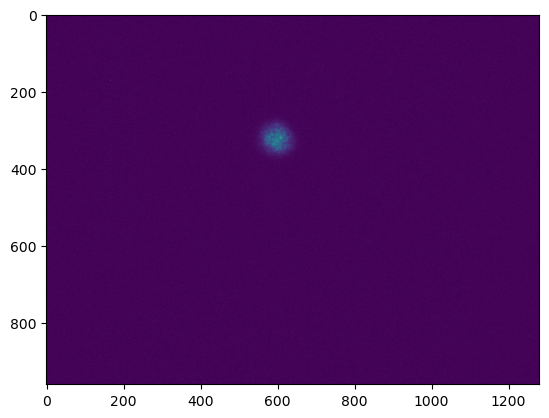

In [6]:
frame=GrabFrame(context)

# in built function that will save the fram to a png

In [ ]:
FC2_PNG=ctypes.c_int(6)
filename="fc2TestImage.png"
error =fc2lib.fc2SaveImage(ctypes.byref(rawImage),filename.encode('utf-8') , FC2_PNG);
print(error)

# Change properties. This is an example of changing the Gain
##### Note to get property info you have to call fc2GetPropertyInfo() or fc2GetProperty() which puts all the information into a fc2Property structure. You need to specify the property type in the fc2Property structure before calling fc2GetPropertyInfo() to actually get the specfic property. Once you have gotten the info in the fc2Property structure you can manipultae it and then call fc2SetProperty() to actually change it on the camera. The difference between fc2PropertyInfo and fc2Property structures is that Info has more like the global properties of what the property can have where as fc2Property is the actual value

In [ ]:
# Look at the property Info
propInfo=fc2PropertyInfo()
propInfo.type=fc2PropertyType.FC2_GAIN
# propInfo.type=fc2PropertyType.FC2_SHUTTER
error=fc2lib.fc2GetPropertyInfo(context,ctypes.byref(propInfo) );
units_string = bytes(propInfo.pUnits).decode('utf-8').rstrip('\x00') 
print(propInfo.absMin)
print(propInfo.absMax)
print(units_string)
# Change the properties 
prop=fc2Property()
prop.type=fc2PropertyType.FC2_GAIN
fc2lib.fc2GetProperty(context,ctypes.byref(prop) );
prop.autoManualMode=0
prop.absValue=30
error=fc2lib.fc2SetProperty(context,ctypes.byref(prop) );
fc2lib.fc2GetProperty(context,ctypes.byref(prop) );
print(prop.autoManualMode)
print(prop.absValue)

# Close the connection to the camera 

In [18]:
error = fc2lib.fc2StopCapture(context);
fc2lib.fc2DestroyContext(context)

0

# ignore everything below here